<a href="https://colab.research.google.com/github/rishitharaj/Deep-Learning/blob/main/Sentiment_Analysis_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import all libraries

import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
# Read the dataset

df = pd.read_csv('/content/drive/MyDrive/nlp_dataset.csv')

print(df.shape)
print(df.head())
print(df['Emotion'].value_counts())


(5937, 2)
                                             Comment Emotion
0  i seriously hate one subject to death but now ...    fear
1                 im so full of life i feel appalled   anger
2  i sit here to write i start to dig out my feel...    fear
3  ive been really angry with r and i feel like a...     joy
4  i feel suspicious if there is no one outside l...    fear
Emotion
anger    2000
joy      2000
fear     1937
Name: count, dtype: int64


In [13]:
# Cleaning the text

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove punctuation only
    return text

df['clean_text'] = df['Comment'].astype(str).apply(clean_text)

print(df[['Comment','clean_text']].head())
print("\nLength stats:\n", df['clean_text'].str.len().describe())


                                             Comment  \
0  i seriously hate one subject to death but now ...   
1                 im so full of life i feel appalled   
2  i sit here to write i start to dig out my feel...   
3  ive been really angry with r and i feel like a...   
4  i feel suspicious if there is no one outside l...   

                                          clean_text  
0  i seriously hate one subject to death but now ...  
1                 im so full of life i feel appalled  
2  i sit here to write i start to dig out my feel...  
3  ive been really angry with r and i feel like a...  
4  i feel suspicious if there is no one outside l...  

Length stats:
 count    5937.000000
mean       97.425973
std        56.196202
min         9.000000
25%        54.000000
50%        86.000000
75%       130.000000
max       298.000000
Name: clean_text, dtype: float64


In [14]:
# Tokenizing and padding

max_words = 12000   # vocabulary size
max_len = 25        # sentence length changed from 60 to 25 after checking the model perfomance

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])

sequences = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(sequences, maxlen=max_len, padding='post')

print("Vocabulary size:", len(tokenizer.word_index))
print("Shape of X:", X.shape)
print("\nFirst sequence sample:\n", X[0])


Vocabulary size: 8980
Shape of X: (5937, 25)

First sequence sample:
 [   2  652  265   74 1368    5  963   19   59    2    3  226    5 1232
   13    0    0    0    0    0    0    0    0    0    0]


In [15]:
le = LabelEncoder()
y = le.fit_transform(df['Emotion'])

print("Unique labels:", np.unique(y))
print("First 10 labels:", y[:10])
print("Shape:", y.shape)
print("Type of one label:", type(y[0]))
print("Mapping:", dict(zip(le.classes_, range(len(le.classes_)))))


Unique labels: [0 1 2]
First 10 labels: [1 0 1 2 1 0 0 0 0 2]
Shape: (5937,)
Type of one label: <class 'numpy.int64'>
Mapping: {'anger': 0, 'fear': 1, 'joy': 2}


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("\nTrain label distribution:", np.bincount(y_train))
print("Test label distribution:", np.bincount(y_test))


Train shape: (4749, 25)
Test shape: (1188, 25)

Train label distribution: [1600 1549 1600]
Test label distribution: [400 388 400]


In [17]:
model = Sequential([
    tf.keras.Input(shape=(25,)),   # updated

    Embedding(input_dim=12000, output_dim=128),
    LSTM(128),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 25, 128)        │     1,536,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,676,035 (6.39 MB)

 Trainable params: 1,676,035 (6.39 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.3429 - loss: 1.0993 - val_accuracy: 0.4638 - val_loss: 1.0354
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5449 - loss: 0.9257 - val_accuracy: 0.8207 - val_loss: 0.5157
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9310 - loss: 0.2285 - val_accuracy: 0.8291 - val_loss: 0.5258
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9621 - loss: 0.1542 - val_accuracy: 0.8847 - val_loss: 0.3339
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9871 - loss: 0.0615 - val_accuracy: 0.8897 - val_loss: 0.4038


In [19]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))



38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Accuracy: 0.8897306397306397
F1 Score: 0.8896988825405798

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       400
           1       0.91      0.86      0.88       388
           2       0.90      0.90      0.90       400

    accuracy                           0.89      1188
   macro avg       0.89      0.89      0.89      1188
weighted avg       0.89      0.89      0.89      1188


Confusion Matrix:

[[363  16  21]
 [ 35 333  20]
 [ 22  17 361]]


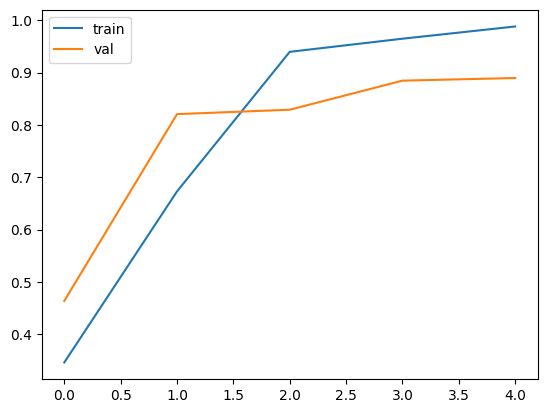

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend(); plt.show()


In [22]:
def predict(text):
    text_clean = text.lower()

    seq = tokenizer.texts_to_sequences([text_clean])
    pad = pad_sequences(seq, maxlen=25)

    probs = model.predict(pad)[0]
    idx = np.argmax(probs)

    print("Sentence:", text)
    print("Predicted:", le.inverse_transform([idx])[0])
    print("Probabilities:")

    for label, p in zip(le.classes_, probs):
        print(f"{label}: {p:.3f}")


In [23]:
predict("i am very happy")
predict("i feel so sad and scared")
predict("i am extremely angry right now")
predict("i feel joyful and excited")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Sentence: i am very happy
Predicted: anger
Probabilities:
anger: 0.673
fear: 0.153
joy: 0.174
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Sentence: i feel so sad and scared
Predicted: fear
Probabilities:
anger: 0.047
fear: 0.936
joy: 0.017
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Sentence: i am extremely angry right now
Predicted: anger
Probabilities:
anger: 0.893
fear: 0.071
joy: 0.036
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Sentence: i feel joyful and excited
Predicted: joy
Probabilities:
anger: 0.097
fear: 0.023
joy: 0.880


In [25]:
# predict("i feel happy")
# predict("i feel very happy")
# predict("i feel so happy")
# predict("i am happy")
